In [1]:
! pip3 install sentencepiece

     |████████████████████████████████| 1.2MB 7.7MB/s 


In [1]:
import pandas as pd
import io
import gc
import scipy
import numpy as np
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
import tensorflow as tf
import tensorflow_hub as hub
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [2]:
def f1_score(actual, predicted):
    # In this problem the evaluation metric is f1-score averaged over the test datapoints.
    avg_f1=0
    for i in range(len(actual)):
        f1=2*(len(set(actual[i]).intersection(set(predicted[i])))/(len(actual[i])+len(predicted[i])))
        avg_f1+=f1
    return avg_f1/len(actual)

In [3]:
import re
def preprocess(description):
  # Actually not required as what we have is titles which usually doesn't contain words that we use for general communication.
    description=description.lower()
    description=re.sub('[-\n\t]+',' ',description)
    description= re.sub(r"won\'t", "will not",description)
    description=re.sub(r"can\'t", "can not",description)
    description=re.sub(r"n\'t", " not",description)
    description=re.sub(r"\'re", " are",description)
    description=re.sub(r"\'s", " is",description)
    description=re.sub(r"\'d", " would",description)
    description=re.sub(r"\'ll", " will",description)
    description=re.sub(r"\'t", " not",description)
    description=re.sub(r"\'ve", " have",description)
    description=re.sub(r"\'m", " am",description)
    description=re.sub('[^a-z0-9]+',' ',description)
    description=re.sub('\s+',' ',description)
    return description.strip()

In [4]:
train=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Case Study 2 - Shopee Product Matching/train.csv')
# Considering label_group as ground truth.
train['targets'] = train['label_group'].map(train.groupby(['label_group'])['posting_id'].unique().to_dict())
train['preprocessed_title']=train.title.map(preprocess)
print(train.shape)
train.head()

(34250, 7)


,posting_id,image,image_phash,title,label_group,targets,preprocessed_title
0,train_129225211,0000a68812bc7e98c42888dfb1c07da0.jpg,94974f937d4c2433,Paper Bag Victoria Secret,249114794,"[train_129225211, train_2278313361]",paper bag victoria secret
1,train_3386243561,00039780dfc94d01db8676fe789ecd05.jpg,af3f9460c2838f0f,"Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...",2937985045,"[train_3386243561, train_3423213080]",double tape 3m vhb 12 mm x 4 5 m original doub...
2,train_2288590299,000a190fdd715a2a36faed16e2c65df7.jpg,b94cb00ed3e50f78,Maling TTS Canned Pork Luncheon Meat 397 gr,2395904891,"[train_2288590299, train_3803689425]",maling tts canned pork luncheon meat 397 gr
3,train_2406599165,00117e4fc239b1b641ff08340b429633.jpg,8514fc58eafea283,Daster Batik Lengan pendek - Motif Acak / Camp...,4093212188,"[train_2406599165, train_3342059966]",daster batik lengan pendek motif acak campur l...
4,train_3369186413,00136d1cf4edede0203f32f05f660588.jpg,a6f319f924ad708c,Nescafe \xc3\x89clair Latte 220ml,3648931069,"[train_3369186413, train_921438619]",nescafe xc3 x89clair latte 220ml


# **1. Using IDF for embedding**

In [ ]:
idf=TfidfVectorizer(binary=True)
embedded_train_idf=idf.fit_transform(train.preprocessed_title.values)
print(embedded_train_idf.shape)

(34250, 25023)


In [ ]:
idf_dot_prods=np.dot(embedded_train_idf,np.transpose(embedded_train_idf))
idf_dot_prods.shape

(34250, 34250)

In [ ]:
for cosine_threshold in [0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85]:
    idf_matches=[]
    for per_posting in idf_dot_prods:
        indices=np.where(per_posting.toarray()>=cosine_threshold)[1]
        idf_matches.append(train.iloc[indices].posting_id.values.tolist())
    print('f1_score with cosine similarity threshold as {} is {}'.format(cosine_threshold, f1_score(train.targets.values,idf_matches)))

f1_score with cosine similarity threshold as 0.5 is 0.6591442130345908
f1_score with cosine similarity threshold as 0.55 is 0.6610173701316998
f1_score with cosine similarity threshold as 0.6 is 0.6505642207941018
f1_score with cosine similarity threshold as 0.65 is 0.633705936355463
f1_score with cosine similarity threshold as 0.7 is 0.6136449739313565
f1_score with cosine similarity threshold as 0.75 is 0.5906088014614402
f1_score with cosine similarity threshold as 0.8 is 0.5671080844917606
f1_score with cosine similarity threshold as 0.85 is 0.5425419274920465


### **Optimum threshold we observed with training data:** 0.55
### **Submission score with 0.55 as threshold: 0.6 (https://www.kaggle.com/chaitanyaboyalla/text-idf-0-55-cossim-threshold)**
### **Submission score with 0.6 as threshold: 0.604 (https://www.kaggle.com/chaitanyaboyalla/text-idf-0-6-cossim-threshold)**


# **2. Using TFIDF for embedding:**

In [ ]:
tfidf=TfidfVectorizer(binary=False)
embedded_train_tfidf=tfidf.fit_transform(train.preprocessed_title.values)
print(embedded_train_tfidf.shape)

(34250, 25023)


In [ ]:
tfidf_dot_prods=np.dot(embedded_train_tfidf,np.transpose(embedded_train_tfidf))
tfidf_dot_prods.shape

(34250, 34250)

In [ ]:
for cosine_threshold in [0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85]:
    tfidf_matches=[]
    for per_posting in tfidf_dot_prods:
        indices=np.where(per_posting.toarray()>=cosine_threshold)[1]
        tfidf_matches.append(train.iloc[indices].posting_id.values.tolist())
    print('f1_score with cosine similarity threshold as {} is {}'.format(cosine_threshold, f1_score(train.targets.values,tfidf_matches)))

f1_score with cosine similarity threshold as 0.5 is 0.6375813106914594
f1_score with cosine similarity threshold as 0.55 is 0.6487080695285977
f1_score with cosine similarity threshold as 0.6 is 0.6451761830928651
f1_score with cosine similarity threshold as 0.65 is 0.6342258832403423
f1_score with cosine similarity threshold as 0.7 is 0.6172896731799803
f1_score with cosine similarity threshold as 0.75 is 0.5951305645519992
f1_score with cosine similarity threshold as 0.8 is 0.5709258525462582
f1_score with cosine similarity threshold as 0.85 is 0.5459191166571772


### **Optimum threshold we observed with training data:** 0.55
### **Submission score with 0.55 as threshold: 0.581 (https://www.kaggle.com/chaitanyaboyalla/text-tfidf-0-55-cossim-threshold)**
### **Submission score with 0.65 as threshold: 0.595 (https://www.kaggle.com/chaitanyaboyalla/text-tfidf-0-65-cossim-threshold):**

# **3. Average W2V(Glove) embedding**

In [ ]:
glove_vectors={}
with io.open('/content/drive/MyDrive/Colab Notebooks/Case Study 2 - Shopee Product Matching/glove.6B.100d.txt', encoding='utf8') as f:
    for line in tqdm(f):
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:],dtype='float32')
        glove_vectors[word] = coefs

400000it [00:11, 34805.12it/s]


### **For what percentage of words in train we have glove vectors?**
### **45.7%**

In [ ]:
print('Percentage of unique words in train have glove vectors: {}'.format(len(set([i for i in tfidf.vocabulary_.keys()]).intersection(set([i for i in glove_vectors.keys()])))/len(tfidf.vocabulary_.keys())*100))

Percentage of unique words in train have glove vectors: 45.68596890860409


In [ ]:
avg_w2v_embedding_train=[]
glove_keys=glove_vectors.keys()
for title in train.preprocessed_title.values:
    embed=np.zeros(100)
    for word in title.split():
        if word in glove_keys:
            embed+=glove_vectors[word]
    avg_w2v_embedding_train.append(embed/len(title.split()))
    
# Making vectors as unit vectors to make Cosine Similarity between -1 and 1.
avg_w2v_embedding_train=np.array([i/np.linalg.norm(i) if np.linalg.norm(i)!=0 else i  for i in avg_w2v_embedding_train])
avg_w2v_embedding_train.shape

(34250, 100)

In [ ]:
del glove_vectors
gc.collect()

55

### **3.1 Using Cosine Similarity**

In [ ]:
chunksize=1024
chunks=len(train)//chunksize if len(train)%chunksize==0 else (len(train)//chunksize)+1
for cosine_threshold in [0.75,0.8,0.85,0.9,0.95]:
    avg_w2v_matches=[]
    for chunk in range(chunks):
        start=chunk*chunksize
        end=min(len(train), start+chunksize)
        chunk_dot=np.dot(avg_w2v_embedding_train[start:end], np.transpose(avg_w2v_embedding_train))
        for per_posting in chunk_dot:
            indices=np.where(per_posting>=cosine_threshold)[0]
            avg_w2v_matches.append(train.iloc[indices].posting_id.values.tolist())
    print('f1_score with cosine similarity threshold as {} is {}'.format(cosine_threshold, f1_score(train.targets.values,avg_w2v_matches)))

f1_score with cosine similarity threshold as 0.75 is 0.34593467110907083
f1_score with cosine similarity threshold as 0.8 is 0.4370897703028301
f1_score with cosine similarity threshold as 0.85 is 0.5113432640039846
f1_score with cosine similarity threshold as 0.9 is 0.539148438965691
f1_score with cosine similarity threshold as 0.95 is 0.5225376738640952


### **Optimum threshold we observed with training data:** 0.9

### **3.2 Using Euclidean Distance**

In [ ]:
nn=NearestNeighbors(n_neighbors=50, metric='minkowski', p=2) 
# p=2 --> Euclidean Distance
# n_neighbors=50 because kaggle doesn't consider more than 50 matches for a posting in this competition
nn.fit(avg_w2v_embedding_train)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='minkowski',
                 metric_params=None, n_jobs=None, n_neighbors=50, p=2,
                 radius=1.0)

In [ ]:
chunksize=4096
chunks=len(train)//chunksize if len(train)%chunksize==0 else (len(train)//chunksize)+1
for euclidean_threshold in [0.3,0.35,0.4,0.45,0.5,0.55]:
    avg_w2v_matches=[]
    for chunk in range(chunks):
        start=chunk*chunksize
        end=min(len(train), start+chunksize)
        distances,indices=nn.kneighbors(avg_w2v_embedding_train[start:end,])
        for i,per_posting in enumerate(distances):
            ind=np.where(per_posting<=euclidean_threshold)[0]
            post_indices=indices[i,ind]
            avg_w2v_matches.append(train.iloc[post_indices].posting_id.values.tolist())
    print('f1_score with euclidean distance threshold as {} is {}'.format(euclidean_threshold, f1_score(train.targets.values,avg_w2v_matches)))

f1_score with euclidean distance threshold as 0.3 is 0.5189741717196286
f1_score with euclidean distance threshold as 0.35 is 0.528924962967108
f1_score with euclidean distance threshold as 0.4 is 0.5366463865762149
f1_score with euclidean distance threshold as 0.45 is 0.5391629001679218
f1_score with euclidean distance threshold as 0.5 is 0.5319605499969092
f1_score with euclidean distance threshold as 0.55 is 0.5113577696334852


### **Optimum threshold we observed with training data:** 0.45

# **4. IDF Weighted W2V(Glove) embedding**

In [ ]:
key_idf=dict(zip([i for i in idf.vocabulary_.keys()], idf.idf_.tolist()))

In [ ]:
idf_w2v_embedding_train=[]
glove_keys=glove_vectors.keys()
idf_keys=key_idf.keys()
for title in train.preprocessed_title.values:
    embed=np.zeros(100)
    idf=0
    for word in title.split():
        if word in glove_keys and word in idf_keys:
            embed+=(glove_vectors[word]*key_idf[word])
            idf+=key_idf[word]
    if idf==0:
        idf_w2v_embedding_train.append(embed)
    else:
        idf_w2v_embedding_train.append(embed/idf)
# Making vectors as unit vectors 
idf_w2v_embedding_train=np.array([i/np.linalg.norm(i) if np.linalg.norm(i)!=0 else i  for i in idf_w2v_embedding_train])
idf_w2v_embedding_train.shape

(34250, 100)

In [ ]:
del glove_vectors
gc.collect()

320

### **4.1 Using Cosine Similarity**

In [ ]:
chunksize=2048
chunks=len(train)//chunksize if len(train)%chunksize==0 else (len(train)//chunksize)+1
for cosine_threshold in [0.75,0.8,0.85,0.9,0.95]:
    idf_w2v_matches=[]
    for chunk in range(chunks):
        start=chunk*chunksize
        end=min(len(train), start+chunksize)
        chunk_dot=np.dot(idf_w2v_embedding_train[start:end], np.transpose(idf_w2v_embedding_train))
        for per_posting in chunk_dot:
            indices=np.where(per_posting>=cosine_threshold)[0]
            idf_w2v_matches.append(train.iloc[indices].posting_id.values.tolist())
    print('f1_score with cosine similarity threshold as {} is {}'.format(cosine_threshold, f1_score(train.targets.values,idf_w2v_matches)))

f1_score with cosine similarity threshold as 0.75 is 0.3762124665421107
f1_score with cosine similarity threshold as 0.8 is 0.46568462474382355
f1_score with cosine similarity threshold as 0.85 is 0.5290880161887223
f1_score with cosine similarity threshold as 0.9 is 0.5443407073918521
f1_score with cosine similarity threshold as 0.95 is 0.5213841710960228


### **Optimum threshold we observed with training data:** 0.9

### **4.2 Using Euclidean Distance**

In [ ]:
nn=NearestNeighbors(n_neighbors=50, metric='minkowski', p=2) 
# p=2 --> Euclidean Distance
# n_neighbors=50 because kaggle doesn't consider more than 50 matches for a posting in this competition
nn.fit(idf_w2v_embedding_train)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='minkowski',
                 metric_params=None, n_jobs=None, n_neighbors=50, p=2,
                 radius=1.0)

In [ ]:
chunksize=4096
chunks=len(train)//chunksize if len(train)%chunksize==0 else (len(train)//chunksize)+1
for euclidean_threshold in [0.3,0.35,0.4,0.45,0.5,0.55]:
    idf_w2v_matches=[]
    for chunk in range(chunks):
        start=chunk*chunksize
        end=min(len(train), start+chunksize)
        distances,indices=nn.kneighbors(idf_w2v_embedding_train[start:end,])
        for i,per_posting in enumerate(distances):
            ind=np.where(per_posting<=euclidean_threshold)[0]
            post_indices=indices[i,ind]
            idf_w2v_matches.append(train.iloc[post_indices].posting_id.values.tolist())
    print('f1_score with euclidean distance threshold as {} is {}'.format(euclidean_threshold, f1_score(train.targets.values,idf_w2v_matches)))

f1_score with euclidean distance threshold as 0.3 is 0.5180716382969818
f1_score with euclidean distance threshold as 0.35 is 0.5282611451040751
f1_score with euclidean distance threshold as 0.4 is 0.5386567265392446
f1_score with euclidean distance threshold as 0.45 is 0.5446161552539963
f1_score with euclidean distance threshold as 0.5 is 0.5441255865579522
f1_score with euclidean distance threshold as 0.55 is 0.5280174985016552


### **Optimum threshold we observed with training data:** 0.45

# **5. TFIDF Weighted W2V(Glove) embedding**

In [ ]:
tfidf_w2v_embedding_train=[]
glove_keys=glove_vectors.keys()
idf_keys=key_idf.keys()
for title in train.preprocessed_title.values:
    embed=np.zeros(100)
    tfidf=0
    for word in title.split():
        if word in glove_keys and word in idf_keys:
            tf=title.split().count(word)
            embed+=(glove_vectors[word]*(key_idf[word]*tf))
            tfidf+=(key_idf[word]*tf)
    if tfidf==0:
        tfidf_w2v_embedding_train.append(embed)
    else:
        tfidf_w2v_embedding_train.append(embed/tfidf)
# Making vectors as unit vectors 
tfidf_w2v_embedding_train=np.array([i/np.linalg.norm(i) if np.linalg.norm(i)!=0 else i  for i in tfidf_w2v_embedding_train])
tfidf_w2v_embedding_train.shape

(34250, 100)

In [ ]:
del glove_vectors
gc.collect()

149

### **5.1 Using Cosine Similarity**

In [ ]:
chunksize=2048
chunks=len(train)//chunksize if len(train)%chunksize==0 else (len(train)//chunksize)+1
for cosine_threshold in [0.75,0.8,0.85,0.9,0.95]:
    tfidf_w2v_matches=[]
    for chunk in range(chunks):
        start=chunk*chunksize
        end=min(len(train), start+chunksize)
        chunk_dot=np.dot(tfidf_w2v_embedding_train[start:end], np.transpose(tfidf_w2v_embedding_train))
        for per_posting in chunk_dot:
            indices=np.where(per_posting>=cosine_threshold)[0]
            tfidf_w2v_matches.append(train.iloc[indices].posting_id.values.tolist())
    print('f1_score with cosine similarity threshold as {} is {}'.format(cosine_threshold, f1_score(train.targets.values,tfidf_w2v_matches)))

f1_score with cosine similarity threshold as 0.75 is 0.3509735175466267
f1_score with cosine similarity threshold as 0.8 is 0.4321380043493437
f1_score with cosine similarity threshold as 0.85 is 0.49327091382413263
f1_score with cosine similarity threshold as 0.9 is 0.5175081879510399
f1_score with cosine similarity threshold as 0.95 is 0.5116941491678668


### **Optimum threshold we observed with training data:** 0.9

### **5.2 Using Euclidean Distance**

In [ ]:
nn=NearestNeighbors(n_neighbors=50, metric='minkowski', p=2) 
# p=2 --> Euclidean Distance
# n_neighbors=50 because kaggle doesn't consider more than 50 matches for a posting in this competition
nn.fit(tfidf_w2v_embedding_train)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='minkowski',
                 metric_params=None, n_jobs=None, n_neighbors=50, p=2,
                 radius=1.0)

In [ ]:
chunksize=4096
chunks=len(train)//chunksize if len(train)%chunksize==0 else (len(train)//chunksize)+1
for euclidean_threshold in [0.3,0.35,0.4,0.45,0.5,0.55]:
    tfidf_w2v_matches=[]
    for chunk in range(chunks):
        start=chunk*chunksize
        end=min(len(train), start+chunksize)
        distances,indices=nn.kneighbors(tfidf_w2v_embedding_train[start:end,])
        for i,per_posting in enumerate(distances):
            ind=np.where(per_posting<=euclidean_threshold)[0]
            post_indices=indices[i,ind]
            tfidf_w2v_matches.append(train.iloc[post_indices].posting_id.values.tolist())
    print('f1_score with euclidean distance threshold as {} is {}'.format(euclidean_threshold, f1_score(train.targets.values,tfidf_w2v_matches)))

f1_score with euclidean distance threshold as 0.3 is 0.5104626522201654
f1_score with euclidean distance threshold as 0.35 is 0.5145884585535
f1_score with euclidean distance threshold as 0.4 is 0.518118131524296
f1_score with euclidean distance threshold as 0.45 is 0.5175630886570123
f1_score with euclidean distance threshold as 0.5 is 0.510911106475017
f1_score with euclidean distance threshold as 0.55 is 0.492469717197438


### **Optimum threshold we observed with training data:** 0.4

# **6. BERT Embeddings**

### *Used Applied AI Course BERT assignment I did for reference*

In [ ]:
title_lenghts=[len(i.split()) for i in train.preprocessed_title.values]
for percentile in [1,5,10,25,50,75,90,95,99,100]:    
    print('{} percentile: {}'.format(percentile, np.percentile(title_lenghts, percentile)))

1 percentile: 2.0
5 percentile: 4.0
10 percentile: 4.0
25 percentile: 6.0
50 percentile: 9.0
75 percentile: 12.0
90 percentile: 15.0
95 percentile: 16.0
99 percentile: 21.0
100 percentile: 82.0


In [ ]:
# Reference from AAIC BERT assignment I did

tf.keras.backend.clear_session()
 
# 100 percentile (to not miss out anything)
max_seq_length = 82+2 ## +2 along with ['CLS'] and ['SEP']
 
#BERT takes 3 inputs
 
#this is input words. Sequence of words represented as integers
input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_word_ids")
 
#mask vector if you are padding anything
input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_mask")
 
#segment vectors. If you are giving only one sentence for the classification, total seg vector is 0. 
#If you are giving two sentenced with [sep] token separated, first seq segment vectors are zeros and 
#second seq segment vector are 1's
segment_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="segment_ids")
 
#bert layer 
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1", trainable=False)
pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
 
#Bert model
#We are using only pooled output not sequence out. 
#If you want to know about those, please read https://www.kaggle.com/questions-and-answers/86510
bert_model = tf.keras.models.Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=pooled_output)

bert_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 84)]         0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 84)]         0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 84)]         0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 768), (None, 109482241   input_word_ids[0][0]             
                                                                 input_mask[0][0]             

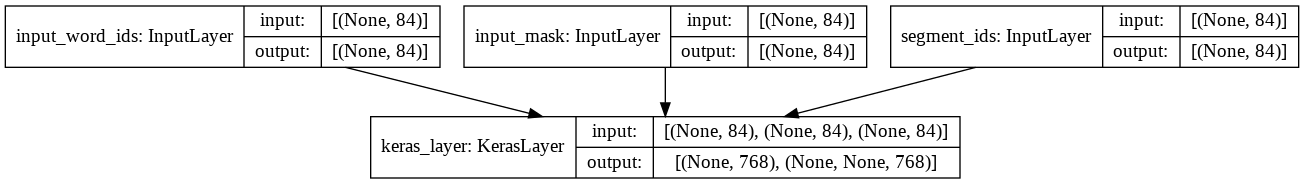

In [ ]:
tf.keras.utils.plot_model(bert_model, show_shapes=True)

In [5]:
bert_layer = hub.KerasLayer("/content/drive/MyDrive/Colab Notebooks/Case Study 2 - Shopee Product Matching/bert_en_uncased_L-24_H-1024_A-16_1", trainable=True)

# This BERT is used for ArcFace training
# Tried with smaller BERT(less param) below but the result is not desirable during ArcFace training
#bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1", trainable=True)

vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()

In [6]:
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/Case Study 2 - Shopee Product Matching/')
from tokenization import FullTokenizer

In [7]:
tokenizer=FullTokenizer(vocab_file, do_lower_case)

In [8]:
max_seq_length=84
title_tokens=[]
for i in tqdm(train.preprocessed_title.values):
    tok=['[CLS]']+tokenizer.tokenize(i)
    if len(tok)>=max_seq_length-1:
        tok=tok[:max_seq_length-1]+['[SEP]']
    else:
        tok=tok+['[SEP]']
        tok=tok+(['[PAD]']*(max_seq_length-len(tok)))
    title_tokens.append(np.array(tokenizer.convert_tokens_to_ids(tok)))
title_tokens=np.array(title_tokens)

title_masks=np.array([np.array([1 if j!=0 else 0 for j in i]) for i in title_tokens])

#As we are not using any sentence seperation in titles
title_segments=np.zeros(title_masks.shape)

title_tokens.shape, title_masks.shape, title_segments.shape

100%|██████████| 34250/34250 [00:06<00:00, 5024.44it/s]


((34250, 84), (34250, 84), (34250, 84))

In [ ]:
bert_embeddings=bert_model.predict([title_tokens, title_masks, title_segments])
bert_embeddings.shape

(34250, 768)

In [ ]:
bert_embeddings=np.array([i/np.linalg.norm(i) if np.linalg.norm(i)!=0 else i  for i in bert_embeddings])

### **6.1 Using Cosine Similarity**

In [ ]:
chunksize=2048
chunks=len(train)//chunksize if len(train)%chunksize==0 else (len(train)//chunksize)+1
for cosine_threshold in [0.991,0.993,0.995,0.997,0.999]:
    bert_matches=[]
    for chunk in range(chunks):
        start=chunk*chunksize
        end=min(len(train), start+chunksize)
        chunk_dot=np.dot(bert_embeddings[start:end], np.transpose(bert_embeddings))
        for per_posting in chunk_dot:
            indices=np.where(per_posting>=cosine_threshold)[0]
            bert_matches.append(train.iloc[indices].posting_id.values.tolist())
    print('f1_score with cosine similarity threshold as {} is {}'.format(cosine_threshold, f1_score(train.targets.values,bert_matches)))

f1_score with cosine similarity threshold as 0.991 is 0.10938407748274505
f1_score with cosine similarity threshold as 0.993 is 0.21085247103517524
f1_score with cosine similarity threshold as 0.995 is 0.3619366875564113
f1_score with cosine similarity threshold as 0.997 is 0.4846932349393558
f1_score with cosine similarity threshold as 0.999 is 0.49012992622755225


In [ ]:
chunksize=2048
chunks=len(train)//chunksize if len(train)%chunksize==0 else (len(train)//chunksize)+1
for cosine_threshold in [0.9991,0.9993,0.9995,0.9997]:
    bert_matches=[]
    for chunk in range(chunks):
        start=chunk*chunksize
        end=min(len(train), start+chunksize)
        chunk_dot=np.dot(bert_embeddings[start:end], np.transpose(bert_embeddings))
        for per_posting in chunk_dot:
            indices=np.where(per_posting>=cosine_threshold)[0]
            bert_matches.append(train.iloc[indices].posting_id.values.tolist())
    print('f1_score with cosine similarity threshold as {} is {}'.format(cosine_threshold, f1_score(train.targets.values,bert_matches)))

f1_score with cosine similarity threshold as 0.9991 is 0.48944534943446044
f1_score with cosine similarity threshold as 0.9993 is 0.4882381758786645
f1_score with cosine similarity threshold as 0.9995 is 0.4870175700449076
f1_score with cosine similarity threshold as 0.9997 is 0.48615889973690773


### *BERT embeddings didn't give desired results as embeddings are not so Cosine(Angle) seperable.*

# **7. Training BERT with ArcFace - Cosine Similarity**
Reference Paper: https://arxiv.org/pdf/1801.07698.pdf

*  *ArcFace is a modification to Softmax to make loss depend only on Cosine Similarity(Dot Product) between feature vector and weight vector. Let's consider Sigmoid for example. We know that the Sigmoid Function is 1/(1+exp-(W.X+b)) where X is the feature vector, W is weight and b is the bias term. Let's consider the plane passes through origin i.e. bias=0 for simplicity. Now Sigmoid=1/(1+exp-(W.X)).*

*   *We know that dot(W,X)=||W||.||X||.Cos(angle between them). We compute this and consider this as probability estimation and calculate loss with that. What if we make W and X unit vectors? The loss depends only on angle between those vectors. That is if angle is less(more cosine similar) the loss is less and during training the model updates weights in such a way that it decreases angle between W and X for particular class label.*

*  *In addition to this, What if we add some angle to actual? Even if angle is less, as we are adding certain angle and making vector less cosine similar the model tries to reduce the added angle during training which in-turn update the weights through back propagation in such a way that the actual angle is reduced. We are just making training harder which results in better learning than actual.*

*  *This process of making loss depend on Angle(Cosine Similarity) and adding additional angle to that to improve training efficiency is called* **ArcFace- Additive Angular Margin Loss**

In [9]:
class ArcFace(tf.keras.layers.Layer):
    
    # Implementation reference from https://github.com/lyakaap/Landmark2019-1st-and-3rd-Place-Solution/blob/master/src/modeling/metric_learning.py
    
    def __init__(self, n_classes, scale, margin, **kwargs):

        super(ArcFace, self).__init__(**kwargs)

        self.n_classes = n_classes
        self.scale = scale
        self.margin = margin
        self.cos_m = tf.math.cos(margin)
        self.sin_m = tf.math.sin(margin)

    def get_config(self):

        config = super().get_config().copy()
        config.update({'n_classes': self.n_classes,'scale': self.scale,'margin': self.margin})
        return config

    def build(self, input_shape):
        super(ArcFace, self).build(input_shape[0])

        self.W = self.add_weight(
            name='W',
            shape=(int(input_shape[0][-1]), self.n_classes),
            initializer='glorot_uniform',
            dtype='float32',
            trainable=True,
            regularizer=None)

    def call(self, inputs):
        X, y = inputs
        y = tf.cast(y, dtype=tf.int32)

        # Normalizing vectors( Unit Vectors ) to make dot product depend only on angle between vectors.
        cosine = tf.matmul(
            tf.math.l2_normalize(X, axis=1),
            tf.math.l2_normalize(self.W, axis=0)
        )

        # Sin(angle)^2 + Cos(angle)^2 = 1
        sine = tf.math.sqrt(1.0 - tf.math.pow(cosine, 2))
        
        # Cos(angle+margin)=Cos(angle)*Cos(margin)-Sin(angle)*Sin(margin)
        phi = cosine * self.cos_m - sine * self.sin_m

        # Add margin only when angle in greater than 90 degrees(Cos(90)=0)
        phi = tf.where(cosine > 0, phi, cosine)

        one_hot = tf.cast(tf.one_hot(y, depth=self.n_classes),dtype=cosine.dtype)
    
        output = (one_hot * phi) + ((1.0 - one_hot) * cosine)
        #
        output *= self.scale
        return output

In [10]:
tf.keras.backend.clear_session()

max_seq_length=84

input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_word_ids")

input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_mask")

segment_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="segment_ids")

label = tf.keras.layers.Input(shape = (), name = 'label')

#bert layer 
pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])

# margin=0.35 radians= 20 degrees approx, scale=30
arc_face=ArcFace(train['label_group'].nunique(),30,0.35, dtype='float32')([pooled_output, label])

out=tf.keras.layers.Softmax(dtype='float32')(arc_face)

Bert_ArcFace_model=tf.keras.models.Model(inputs=[input_word_ids,input_mask,segment_ids,label], outputs=out)
Bert_ArcFace_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 84)]         0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 84)]         0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 84)]         0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 1024), (None 335141889   input_word_ids[0][0]             
                                                                 input_mask[0][0]             

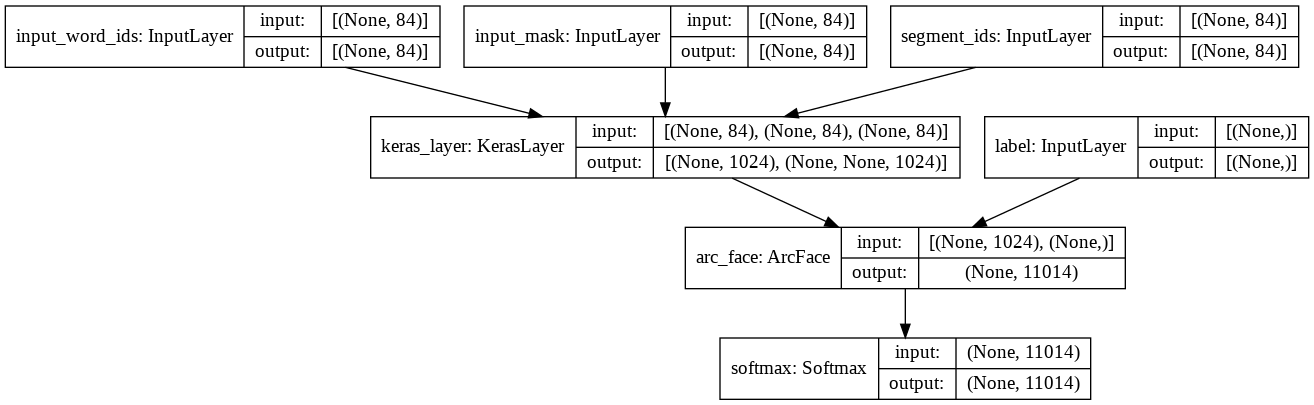

In [11]:
tf.keras.utils.plot_model(Bert_ArcFace_model, show_shapes=True)

In [11]:
x=train['preprocessed_title']
encoder = LabelEncoder()
train['label'] = encoder.fit_transform(train['label_group'])
y=train['label'].values

# We cannot choose test_size less than 0.33 because test_size should be more than number of class labels (11014)
X_train, X_val, y_train, y_val=train_test_split(x, y, test_size=0.33, stratify=y)

X_train.shape,X_val.shape,y_train.shape,y_val.shape

((22947,), (11303,), (22947,), (11303,))

In [12]:
train_tokens=[]
for i in tqdm(X_train.values):
    tok=['[CLS]']+tokenizer.tokenize(i)
    if len(tok)>=max_seq_length-1:
        tok=tok[:max_seq_length-1]+['[SEP]']
    else:
        tok=tok+['[SEP]']
        tok=tok+(['[PAD]']*(max_seq_length-len(tok)))
    train_tokens.append(np.array(tokenizer.convert_tokens_to_ids(tok)))
train_tokens=np.array(train_tokens)

train_masks=np.array([np.array([1 if j!=0 else 0 for j in i]) for i in train_tokens])

#As we are not using any sentence seperation in titles
train_segments=np.zeros(train_masks.shape)

train_tokens.shape, train_masks.shape, train_segments.shape

100%|██████████| 22947/22947 [00:04<00:00, 4757.99it/s]


((22947, 84), (22947, 84), (22947, 84))

In [13]:
max_seq_length=84
val_tokens=[]
for i in tqdm(X_val.values):
    tok=['[CLS]']+tokenizer.tokenize(i)
    if len(tok)>=max_seq_length-1:
        tok=tok[:max_seq_length-1]+['[SEP]']
    else:
        tok=tok+['[SEP]']
        tok=tok+(['[PAD]']*(max_seq_length-len(tok)))
    val_tokens.append(np.array(tokenizer.convert_tokens_to_ids(tok)))
val_tokens=np.array(val_tokens)

val_masks=np.array([np.array([1 if j!=0 else 0 for j in i]) for i in val_tokens])

#As we are not using any sentence seperation in titles
val_segments=np.zeros(val_masks.shape)

val_tokens.shape, val_masks.shape, val_segments.shape

100%|██████████| 11303/11303 [00:02<00:00, 4656.43it/s]


((11303, 84), (11303, 84), (11303, 84))

In [14]:
train_data=[train_tokens, train_masks, train_segments, y_train]
val_data=[val_tokens, val_masks, val_segments, y_val]

In [16]:
class save(tf.keras.callbacks.Callback):
    
    def on_epoch_end(self, epoch, logs={}):
        #saving model on every epoch
        filepath='/content/drive/MyDrive/Colab Notebooks/Case Study 2 - Shopee Product Matching/BERT ArcFace models/BERT_ArcFace_epoch_'+str(epoch+1)+'.hdf5'
        self.model.save_weights(filepath)
        
save=save()

In [18]:
def scheduler(epoch, lr):
    learning_rate=lr
    if (epoch+1)%2==0:
        learning_rate=learning_rate*0.85
    return learning_rate
adap_lr=tf.keras.callbacks.LearningRateScheduler(scheduler)

In [17]:
Bert_ArcFace_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.00001), loss=[tf.keras.losses.SparseCategoricalCrossentropy()], metrics = [tf.keras.metrics.SparseCategoricalAccuracy()])
Bert_ArcFace_model.fit(train_data, y_train, epochs=30, batch_size=32, validation_data=(val_data, y_val), callbacks=[save])

Epoch 1/30
718/718 [==============================] - 840s 1s/step - loss: 14.0490 - sparse_categorical_accuracy: 0.0000e+00 - val_loss: 19.0250 - val_sparse_categorical_accuracy: 0.0000e+00
Epoch 2/30
718/718 [==============================] - 813s 1s/step - loss: 11.8228 - sparse_categorical_accuracy: 0.0000e+00 - val_loss: 11.3504 - val_sparse_categorical_accuracy: 0.0000e+00
Epoch 3/30
718/718 [==============================] - 814s 1s/step - loss: 11.5943 - sparse_categorical_accuracy: 0.0000e+00 - val_loss: 11.7645 - val_sparse_categorical_accuracy: 0.0000e+00
Epoch 4/30
718/718 [==============================] - 814s 1s/step - loss: 13.5871 - sparse_categorical_accuracy: 0.0017 - val_loss: 14.5296 - val_sparse_categorical_accuracy: 0.0027
Epoch 5/30
718/718 [==============================] - 814s 1s/step - loss: 15.9916 - sparse_categorical_accuracy: 0.0079 - val_loss: 15.9226 - val_sparse_categorical_accuracy: 0.0126
Epoch 6/30
718/718 [==============================] - 836s 1s

In [12]:
Bert_ArcFace_model.load_weights('/content/drive/MyDrive/Colab Notebooks/Case Study 2 - Shopee Product Matching/BERT ArcFace models/BERT_ArcFace_epoch_26.hdf5')

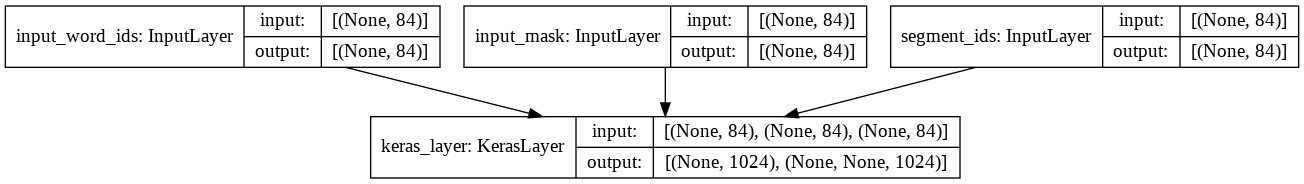

In [13]:
tf.keras.backend.clear_session()

input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_word_ids")
input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_mask")
segment_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="segment_ids")

pooled_embed,seq_embed=Bert_ArcFace_model.layers[3]([input_word_ids, input_mask, segment_ids])

bert_arcface_encoder=tf.keras.models.Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=[pooled_embed])
tf.keras.utils.plot_model(bert_arcface_encoder, show_shapes=True)

In [14]:
bert_embeddings=bert_arcface_encoder.predict([title_tokens, title_masks, title_segments])
# Making Vectors to be of Unit lenght to get Cosine Similarity between -1 and 1
bert_embeddings=np.array([i/np.linalg.norm(i) if np.linalg.norm(i)!=0 else i  for i in bert_embeddings])
bert_embeddings.shape

(34250, 1024)

### **7.1 Cosine Similarity**

In [15]:
chunksize=2048
chunks=len(train)//chunksize if len(train)%chunksize==0 else (len(train)//chunksize)+1
for cosine_threshold in [0.35,0.4,0.45,0.5,0.55,0.6]:
    bert_matches=[]
    for chunk in range(chunks):
        start=chunk*chunksize
        end=min(len(train), start+chunksize)
        chunk_dot=np.dot(bert_embeddings[start:end], np.transpose(bert_embeddings))
        for per_posting in chunk_dot:
            indices=np.where(per_posting>=cosine_threshold)[0]
            bert_matches.append(train.iloc[indices].posting_id.values.tolist())
    print('f1_score with cosine similarity threshold as {} is {}'.format(cosine_threshold, f1_score(train.targets.values,bert_matches)))

f1_score with cosine similarity threshold as 0.35 is 0.8053618401247289
f1_score with cosine similarity threshold as 0.4 is 0.828428044168913
f1_score with cosine similarity threshold as 0.45 is 0.8338048828326806
f1_score with cosine similarity threshold as 0.5 is 0.8301533178159612
f1_score with cosine similarity threshold as 0.55 is 0.8231070465561152
f1_score with cosine similarity threshold as 0.6 is 0.8139163921290603


### **Optimum threshold we observed with training data:** 0.45
### **Submission: https://www.kaggle.com/chaitanyaboyalla/bert-arcface-cosine-threshold**
### **Submission score with 0.45 as threshold: 0.577 (Version 6)**
### **Submission score with 0.5 as threshold: 0.581 (Version 5)**

### **7.2 Euclidean Distance**

In [15]:
nn=NearestNeighbors(n_neighbors=50, metric='minkowski', p=2) 
# p=2 --> Euclidean Distance
# n_neighbors=50 because kaggle doesn't consider more than 50 matches for a posting in this competition
nn.fit(bert_embeddings)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='minkowski',
                 metric_params=None, n_jobs=None, n_neighbors=50, p=2,
                 radius=1.0)

In [ ]:
chunksize=2048
chunks=len(train)//chunksize if len(train)%chunksize==0 else (len(train)//chunksize)+1
for euclidean_threshold in [0.7,0.75,0.8,0.85,0.9]:
    bert_matches=[]
    for chunk in range(chunks):
        start=chunk*chunksize
        end=min(len(train), start+chunksize)
        distances,indices=nn.kneighbors(bert_embeddings[start:end,])
        for i,per_posting in enumerate(distances):
            ind=np.where(per_posting<=euclidean_threshold)[0]
            post_indices=indices[i,ind]
            bert_matches.append(train.iloc[post_indices].posting_id.values.tolist())
    print('f1_score with euclidean distance threshold as {} is {}'.format(euclidean_threshold, f1_score(train.targets.values,bert_matches)))

f1_score with euclidean distance threshold as 0.7 is 0.7630576531838613
f1_score with euclidean distance threshold as 0.75 is 0.7813163764398094
f1_score with euclidean distance threshold as 0.8 is 0.7944628602370533
f1_score with euclidean distance threshold as 0.85 is 0.8046952149162264
f1_score with euclidean distance threshold as 0.9 is 0.8148519779421138


In [17]:
chunksize=2048
chunks=len(train)//chunksize if len(train)%chunksize==0 else (len(train)//chunksize)+1
for euclidean_threshold in [0.95,1.0,1.05,1.1,1.15]:
    bert_matches=[]
    for chunk in range(chunks):
        start=chunk*chunksize
        end=min(len(train), start+chunksize)
        distances,indices=nn.kneighbors(bert_embeddings[start:end,])
        for i,per_posting in enumerate(distances):
            ind=np.where(per_posting<=euclidean_threshold)[0]
            post_indices=indices[i,ind]
            bert_matches.append(train.iloc[post_indices].posting_id.values.tolist())
    print('f1_score with euclidean distance threshold as {} is {}'.format(euclidean_threshold, f1_score(train.targets.values,bert_matches)))

f1_score with euclidean distance threshold as 0.95 is 0.8231309600458431
f1_score with euclidean distance threshold as 1.0 is 0.8300282975160427
f1_score with euclidean distance threshold as 1.05 is 0.8335928102055444
f1_score with euclidean distance threshold as 1.1 is 0.8269489263073421
f1_score with euclidean distance threshold as 1.15 is 0.7964130126678556


### **Optimum threshold we observed with training data:** 1.05
### **Submission: https://www.kaggle.com/chaitanyaboyalla/bert-arcface-euclidean-threshold**
### **Submission score with 1.05 as threshold: 0.577 (Version 3)**
### **Submission score with 1.0 as threshold: 0.581 (Version 2)**

***Scores with Cosine and Euclidean be similar as they are proportional because I converted embeddings into Unit Vectors.***